<a href="https://colab.research.google.com/github/shizoda/education/blob/main/machine_learning/transformer/text_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import torch
assert torch.cuda.is_available()

# CUDA 利用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# 解説: Hugging Face Transformers ライブラリを使用して、事前学習済みモデルをロードします。
# 今回は t5-small モデルを使用します。

# 学習済みモデルとトークナイザをロード
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [84]:
# 要約対象の入力文
input_text = "The cat, which is fluffy and white, is chasing a small mouse. The mouse, quick and clever, darts under the table, hoping to find refuge."
# エンコーダの処理を理解するために、エンコーダ入力を準備
# 解説: エンコーダに渡す入力は「Prefix + 入力文」の形式で与えます。
task_prefix = "summarize: "
input_text_with_prefix = task_prefix + input_text

# トークナイズ (テキストをトークンに変換)
input_ids = tokenizer(input_text_with_prefix, return_tensors="pt").input_ids
input_ids = input_ids.to(device)

print("Tokenized Input IDs:", input_ids)
print("Tokens:", tokenizer.convert_ids_to_tokens(input_ids[0]))


Tokenized Input IDs: tensor([[21603,    10,    37,  1712,     6,    84,    19, 25155,    11,   872,
             6,    19,     3, 22020,     3,     9,   422,  8429,     5,    37,
          8429,     6,  1704,    11, 13183,     6,   649,    17,     7,   365,
             8,   953,     6,  6055,    12,   253, 14330,     5,     1]],
       device='cuda:0')
Tokens: ['▁summarize', ':', '▁The', '▁cat', ',', '▁which', '▁is', '▁fluffy', '▁and', '▁white', ',', '▁is', '▁', 'chasing', '▁', 'a', '▁small', '▁mouse', '.', '▁The', '▁mouse', ',', '▁quick', '▁and', '▁clever', ',', '▁dar', 't', 's', '▁under', '▁the', '▁table', ',', '▁hoping', '▁to', '▁find', '▁refuge', '.', '</s>']


In [85]:
# エンコーダの出力を取得
# 解説: エンコーダは入力文を受け取り、トークンの「特徴」を圧縮した表現 (エンコーダの出力) を生成します。
with torch.no_grad():
    encoder_outputs = model.encoder(input_ids=input_ids)

# エンコーダの出力
print("Encoder Outputs Shape:", encoder_outputs.last_hidden_state.shape)
# 解説: 出力は [バッチサイズ, シーケンス長, 隠れ層の次元数] の形状を持ちます。

Encoder Outputs Shape: torch.Size([1, 39, 512])


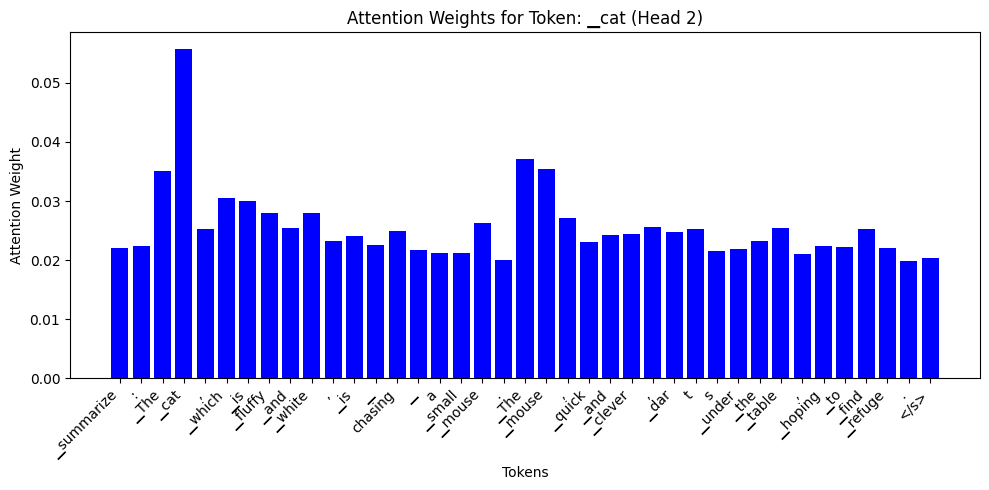

In [87]:
# Query, Key, Value の役割を理解するための解説
# Query: 注目したい単語 (またはトークン) の情報を持つベクトル。
# Key: 各トークンの「特徴」を表すベクトル。
# Value: Key に基づいて取り出される実際の情報を持つベクトル。
# Self-Attention の仕組み: Query と Key の内積を計算し、他のトークンへの重要度 (スコア) を取得します。そのスコアを基に Value を重み付けして足し合わせ、各トークンに関連する情報を生成します。

# エンコーダの出力が要約作成にどう役立つかを観察する
# 解説: エンコーダの出力は各トークンの意味を含む圧縮された特徴表現です。
# この特徴表現は文全体の文脈を捉えており、要約を生成する際に役立ちます。
# 具体的には、デコーダがエンコーダ出力を利用して重要な情報を抽出し、短い文にまとめます。

# トークン間の重みを可視化するためのコード
# 特定のトークンに着目し、他のトークンへの重みを可視化します。
def visualize_attention_weights(encoder_outputs, tokenizer, input_ids, target_token_index, head_index):
    # CUDA対応: エンコーダ出力をCPUに移動し、特定のヘッドのアテンションを見る
    attention_scores = encoder_outputs.last_hidden_state[0].cpu().detach().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

    # マルチヘッドアテンションの各ヘッドを分割
    num_heads = attention_scores.shape[-1] // len(tokens)  # ヘッド数を計算
    head_dimension = attention_scores.shape[-1] // num_heads

    # 指定されたヘッドのスコアを抽出
    head_start = head_index * head_dimension
    head_end = head_start + head_dimension
    target_token_vector = attention_scores[target_token_index, head_start:head_end]

    # 内積を計算して重みを得る (指定ヘッド内でのみ計算)
    attention_weights = []
    for token_index in range(len(tokens)):
        token_vector = attention_scores[token_index, head_start:head_end]
        score = (token_vector @ target_token_vector).item()
        attention_weights.append(score)

    # スコアを正規化 (Softmax)
    attention_weights = torch.softmax(torch.tensor(attention_weights), dim=0).numpy()

    # 可視化
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(tokens)), attention_weights, tick_label=tokens, color="blue")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.title(f"Attention Weights for Token: {tokens[target_token_index]} (Head {head_index})")
    plt.xlabel("Tokens")
    plt.ylabel("Attention Weight")
    plt.tight_layout()
    plt.show()



# 特定のトークン (例: 3番目のトークン) に注目
visualize_attention_weights(encoder_outputs, tokenizer, input_ids, target_token_index=3, head_index=2)



In [80]:
# 解説: モデル全体を使い、要約を生成します。
output_ids = model.generate(input_ids, max_length=50, num_beams=4, early_stopping=True)
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("\nInput Text:", input_text)
print("\nGenerated Summary:", output_text)

# **学びのポイント:**
# 1. エンコーダが入力文の意味をコンパクトに表現し、デコーダに受け渡す。
# 2. Query, Key, Value によるトークン間の重み付けが、どの単語が重要かを決定する。
# 3. エンコーダの出力がデコーダでどのように利用されるかを観察する。

# **演習:**
# 次の課題を試してください。
# 1. 入力文を変えて、生成される要約がどのように変わるか確認する。
# 2. `max_length` や `num_beams` を調整し、生成結果を観察する。
# 3. `encoder_outputs.last_hidden_state` の内容を可視化してみる (例: 特徴のヒートマップを作成)。
# 4. エンコーダ出力の特定のトークンに対する影響を観察し、デコーダがどの情報を利用しているかを推測する。



Input Text: The cat, which is fluffy and white, is chasing a small mouse.

Generated Summary: the cat, which is fluffy and white, is chasing a small mouse.
